In [1]:
import numpy as np
import pandas as pd
from tools import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib
%matplotlib inline

In [2]:
comp_name = 'santander-value-prediction-challenge'
train_path = '../data/train.csv'
test_path = '../data/test.csv'

In [3]:
trn = pd.read_csv(train_path)
tst = pd.read_csv(test_path)

In [4]:
drop_cols = ['ID', 'target']
X = trn.drop(drop_cols, axis=1)
y = trn.target.values.astype(np.int32)

x_trn, x_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=2018)

In [5]:
model = RandomForestRegressor(n_estimators=20, oob_score=True, 
                              max_depth=10, min_samples_leaf=10, 
                              random_state=2018, n_jobs=-1)
%time model.fit(x_trn, y_trn)

CPU times: user 18.2 s, sys: 156 ms, total: 18.4 s
Wall time: 2.32 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=True, random_state=2018,
           verbose=0, warm_start=False)

In [6]:
evaluate(model, x_trn, y_trn, x_val, y_val, rmsle)

# trn loss : 1.86302689495
# val loss : 1.99915397023
# trn R2 : 0.349567050331
# val R2 : 0.292105707347
# OOB_score : 0.178236166967


In [7]:
feature_imp = pd.DataFrame({'col': x_trn.columns.tolist(),
                            'imp': model.feature_importances_})
feature_imp.sort_values(by='imp', ascending=False, inplace=True)

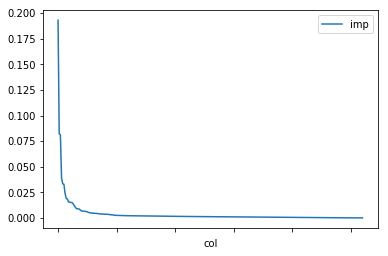

In [8]:
feature_imp[feature_imp.imp > 0].plot('col', 'imp')

In [9]:
# 261 cols
keep_cols = feature_imp[feature_imp.imp > 0].col.values.tolist()
x_trn, x_val, y_trn, y_val = train_test_split(X[keep_cols], y, test_size=0.2, random_state=2018)
%time model.fit(x_trn, y_trn)
evaluate(model, x_trn, y_trn, x_val, y_val, rmsle)

CPU times: user 2.3 s, sys: 127 ms, total: 2.43 s
Wall time: 275 ms
# trn loss : 1.86302689495
# val loss : 1.99915397023
# trn R2 : 0.349567050331
# val R2 : 0.292105707347
# OOB_score : 0.178236166967


In [10]:
# 16 cols
keep_cols = feature_imp[feature_imp.imp > 0.01].col.values.tolist()
x_trn, x_val, y_trn, y_val = train_test_split(X[keep_cols], y, test_size=0.2, random_state=2018)
%time model.fit(x_trn, y_trn)
evaluate(model, x_trn, y_trn, x_val, y_val, rmsle)

CPU times: user 276 ms, sys: 7.58 ms, total: 284 ms
Wall time: 188 ms
# trn loss : 1.81737510511
# val loss : 1.94082404581
# trn R2 : 0.33386114906
# val R2 : 0.302464760019
# OOB_score : 0.193512235346


In [ ]:
# feature interaction between 16

In [11]:
keep_cols = feature_imp[feature_imp.imp > 0.01].col.values.tolist()
df = X[keep_cols].copy()

In [12]:
import itertools

for pair in itertools.combinations(keep_cols, r=2):
    df['_add_'.join(pair)] = df[pair[0]] + df[pair[1]]
    df['_sub_'.join(pair)] = df[pair[0]] - df[pair[1]]
    df['_mul_'.join(pair)] = df[pair[0]] * df[pair[1]]
    df['_div_'.join(pair)] = df[pair[0]] / (df[pair[1]] + 1)

In [13]:
x_trn, x_val, y_trn, y_val = train_test_split(df, y, test_size=0.2, random_state=2018)

In [17]:
# create dataset for lightgbm
import lightgbm as lgb
lgb_train = lgb.Dataset(x_trn, np.log1p(y_trn))
lgb_eval = lgb.Dataset(x_val, np.log1p(y_val), reference=lgb_train)

In [18]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [19]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's rmse: 1.76257
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.74066
[3]	valid_0's rmse: 1.72084
[4]	valid_0's rmse: 1.70237
[5]	valid_0's rmse: 1.68633
[6]	valid_0's rmse: 1.6699
[7]	valid_0's rmse: 1.65469
[8]	valid_0's rmse: 1.64087
[9]	valid_0's rmse: 1.62824
[10]	valid_0's rmse: 1.61614
[11]	valid_0's rmse: 1.606
[12]	valid_0's rmse: 1.59645
[13]	valid_0's rmse: 1.58799
[14]	valid_0's rmse: 1.57838
[15]	valid_0's rmse: 1.57129
[16]	valid_0's rmse: 1.56406
[17]	valid_0's rmse: 1.55647
[18]	valid_0's rmse: 1.55045
[19]	valid_0's rmse: 1.54451
[20]	valid_0's rmse: 1.54058
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 1.54058


In [ ]:
x_tst = tst[keep_cols]

for pair in itertools.combinations(keep_cols, r=2):
    x_tst['_add_'.join(pair)] = x_tst[pair[0]] + x_tst[pair[1]]
    x_tst['_sub_'.join(pair)] = x_tst[pair[0]] - x_tst[pair[1]]
    x_tst['_mul_'.join(pair)] = x_tst[pair[0]] * x_tst[pair[1]]
    x_tst['_div_'.join(pair)] = x_tst[pair[0]] / (x_tst[pair[1]] + 1)

In [20]:
lgb_tst = gbm.predict(x_tst, num_iteration=gbm.best_iteration)

In [21]:
tst_subm = pd.DataFrame({'ID': tst.ID, 'target': np.exp(lgb_tst) - 1 })

In [22]:
fname = 'lgbm.16feat'

In [23]:
tst_subm.to_csv(fname, index=False)

In [24]:
submit_kaggle_result(comp_name, fname, msg='lgbm.16feat')

In [25]:
check_kaggle_result(comp_name, fname)


fileName           date                 description       status    publicScore  privateScore  
-----------------  -------------------  ----------------  --------  -----------  ------------  
lgbm.16feat        2018-10-18 01:36:49  lgbm.16feat       complete  1.57676      1.53769       (THIS) (BEST) 
lgbm.16feat        2018-10-18 01:31:50  lgbm.16feat       complete  1.88269      1.87645       (THIS) 
lgbm.16feat        2018-10-17 10:29:39  lgbm.16feat       complete  1.57676      1.53769       (THIS) (BEST) 
baseline.20181017  2018-10-17 08:55:50  baseline.rf.noFE  complete  1.93257      1.87086       
baseline.20181017  2018-10-17 08:54:39  baseline.rf.noFE  complete  1.93257      1.87086       
baseline.20181017  2018-10-17 08:52:46  baseline.rf.noFE  complete  1.93257      1.87086       
baseline.20181017  2018-10-17 08:51:11  baseline.rf.noFE  complete  1.93257      1.87086       
baseline.20181017  2018-10-17 08:20:24  baseline.rf.noFE  complete  1.94841      1.89284       

